`--- Day 4: Repose Record ---`

In [ ]:
from collections import Counter
import re

In [ ]:
input_data = open('input.txt', 'r').read().splitlines()

In [ ]:
input_data = sorted(input_data) # yyyy-mm-dd hh:mm format sorts correctly lexically

In [4]:
class Guard(object):
    
    def __init__(self, guard_id):
        self.guard_id = guard_id
        self.counts = Counter()
        self.sleeptime = 0
        self.cached_most_frequent = None # might be premature optimisation... not sure how expensive self.most_frequent() is
        
    def sleep(self, start, end):
        if end <= start:
            raise ValueError('end must be after start!')
        self.counts += Counter(range(start, end))
        self.sleeptime += end - start
        self.cached_most_frequent = None # invalidate cache
        
    def most_frequent(self):
        if self.cached_most_frequent is None:
            most_common = self.counts.most_common(1)
            if len(most_common) == 0: # not yet slept
                maxv = 0
            else:
                maxv = most_common[0][1]
            self.cached_most_frequent = [k for k,v in self.counts.items() if v == maxv]
        return self.cached_most_frequent
        
    def __str__(self):
        return f'Guard #{self.guard_id}: sleeptime = {self.sleeptime}, most_frequent = {self.most_frequent()}'
    
    __repr__ = __str__

In [5]:
def process_records(data):
    guard_on_duty_id = None
    guard_on_duty = None
    
    guard_ids = set()
    guards = {}
    
    sleep_start = None
    
    # The following assumes that a "falls asleep" for a guard is always paired with a corresponding "wakes up"
    # that is true for my input data.  In general, this should allow for a guard falling asleep, but not waking up
    # before the end of the hour (detect that condition and log a sleep of (start_time, 60))
    for l in data:
        if 'Guard' in l:
            guard_on_duty_id = int(re.findall(r'#(\d+)', l)[0])
            if guard_on_duty_id in guard_ids:
                guard_on_duty = guards[guard_on_duty_id]
            else:
                guard_on_duty = Guard(guard_on_duty_id)
                guards[guard_on_duty_id] = guard_on_duty
                guard_ids.add(guard_on_duty_id)
        else:
            minute = int(re.findall(r'\d+', l)[4])
            if 'falls' in l:
                sleep_start = minute
            elif 'wakes' in l:
                guard_on_duty.sleep(sleep_start, minute)
                sleep_start = None
            else:
                raise NotImplementedError(f'unrecognised line \'{l}\'')
    
    return guard_ids, guards

def strategy1(guard_ids, guards):
    max_sleeptime = max(guards[gid].sleeptime for gid in guard_ids)
    sleepiest = [gid for gid in guard_ids if guards[gid].sleeptime == max_sleeptime][0] # assumption that there is only one
    return sleepiest * guards[sleepiest].most_frequent()[0]

# Part 1
## test case

In [6]:
test_data = '''[1518-11-01 00:00] Guard #10 begins shift
[1518-11-01 00:05] falls asleep
[1518-11-01 00:25] wakes up
[1518-11-01 00:30] falls asleep
[1518-11-01 00:55] wakes up
[1518-11-01 23:58] Guard #99 begins shift
[1518-11-02 00:40] falls asleep
[1518-11-02 00:50] wakes up
[1518-11-03 00:05] Guard #10 begins shift
[1518-11-03 00:24] falls asleep
[1518-11-03 00:29] wakes up
[1518-11-04 00:02] Guard #99 begins shift
[1518-11-04 00:36] falls asleep
[1518-11-04 00:46] wakes up
[1518-11-05 00:03] Guard #99 begins shift
[1518-11-05 00:45] falls asleep
[1518-11-05 00:55] wakes up'''.splitlines()

# test case
assert(strategy1(*process_records(test_data)) == 240)

## answer

In [7]:
print(f'Part 1: {strategy1(*process_records(input_data))}')

Part 1: 71748


# Part 2

In [8]:
def strategy2(guard_ids, guards):
    gid, max_frequency, count = max([(gid,
                                      None if len(guards[gid].most_frequent()) == 0 else guards[gid].most_frequent()[0], 
                                      0 if len(guards[gid].most_frequent()) == 0 else guards[gid].counts[guards[gid].most_frequent()[0]])
                                     for gid in guard_ids],
                                    key=lambda x: x[2])
    return gid * max_frequency
    

## test case

In [9]:
assert(strategy2(*process_records(test_data)) == 4455)

## answer

In [10]:
print(f'Part 2: {strategy2(*process_records(input_data))}')

Part 2: 106850


# visuals

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
guard_ids, guards = process_records(input_data)

In [29]:
guard_ids

{131,
 151,
 193,
 229,
 821,
 1091,
 1171,
 1237,
 1451,
 1709,
 1913,
 1993,
 2083,
 2137,
 2297,
 2399,
 2731,
 2797,
 2851,
 2939,
 3373,
 3433,
 3491}

<BarContainer object of 54 artists>

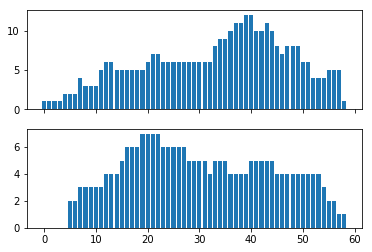

In [31]:
fig, ax = plt.subplots(2, 1, sharex=True, squeeze=True)
ax[0].bar(*list(zip(*guards[131].counts.items())))
ax[1].bar(*list(zip(*guards[151].counts.items())))

In [64]:
import seaborn as sns

In [65]:
import pandas as pd
import numpy as np

In [110]:
guard_ids, guards = process_records(input_data)
guard_ids = sorted(list(guard_ids))

foo = [list(zip(*guards[i].counts.items())) for i in guard_ids]

foo = [x if len(x) == 2 else [tuple(range(60)), (0,)*60] for x in foo]

In [111]:
series = [pd.Series(data=x[1], index=x[0], name=f'Guard #{i}') for x, i in zip(foo, guard_ids)]

In [112]:
df = pd.concat(series, axis=1).fillna(0.)

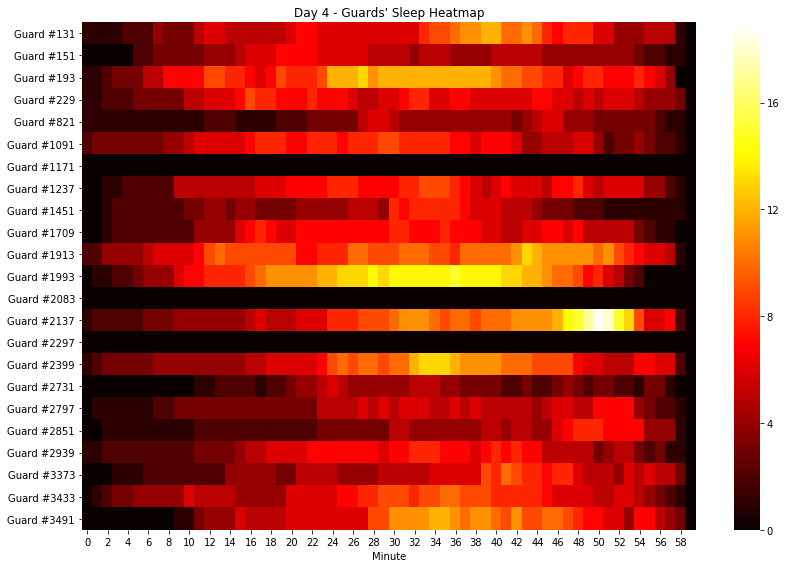

In [121]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.T, ax=ax, cmap='hot')
ax.set_xlabel('Minute')
ax.set_title('Day 4 - Guards\' Sleep Heatmap')
plt.tight_layout()
plt.savefig('sleep_heatmap.png')
plt.show()

In [115]:
series

[7      4
 8      3
 9      3
 10     3
 11     5
 12     6
 13     6
 14     5
 15     5
 16     5
 17     5
 18     5
 19     5
 20     6
 21     7
 22     7
 23     6
 24     6
 25     6
 26     6
 27     6
 28     6
 29     6
 30     6
 31     6
 32     6
 33     8
 34     9
 35     9
 36    10
 37    11
 38    11
 39    12
 40    12
 41    10
 42    10
 43    11
 44    10
 45     8
 46     7
 47     8
 48     8
 49     8
 50     6
 51     6
 55     5
 56     5
 52     4
 53     4
 57     5
 58     1
 54     4
 0      1
 1      1
 2      1
 3      1
 4      2
 5      2
 6      2
 Name: Guard #131, dtype: int64, 16    6
 17    6
 18    6
 19    7
 20    7
 21    7
 22    7
 23    6
 24    6
 25    6
 26    6
 27    6
 7     3
 8     3
 9     3
 10    3
 11    3
 12    4
 13    4
 14    4
 15    5
 28    5
 29    5
 30    5
 31    5
 32    4
 33    5
 34    5
 35    5
 36    4
 37    4
 38    4
 39    4
 40    5
 41    5
 42    5
 43    5
 44    5
 45    4
 46    4
 47    4
 48    4


In [74]:
foo

[[(7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   55,
   56,
   52,
   53,
   57,
   58,
   54,
   0,
   1,
   2,
   3,
   4,
   5,
   6),
  (4,
   3,
   3,
   3,
   5,
   6,
   6,
   5,
   5,
   5,
   5,
   5,
   5,
   6,
   7,
   7,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   8,
   9,
   9,
   10,
   11,
   11,
   12,
   12,
   10,
   10,
   11,
   10,
   8,
   7,
   8,
   8,
   8,
   6,
   6,
   5,
   5,
   4,
   4,
   5,
   1,
   4,
   1,
   1,
   1,
   1,
   2,
   2,
   2)],
 ([0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   